In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm
torch.manual_seed(42)

In [2]:
def imshow(sample_element, shape = (28, 28)):
    plt.imshow(sample_element[0].numpy().reshape(shape), cmap='gray')
    plt.title('Label = ' + str(sample_element[1]))
    plt.show()

In [3]:
class Complexify(object):
    """
    cast to complex numbers
    """

    def __init__(self):
        pass

    def __call__(self, sample):
        img = sample.type(torch.complex64)
        img = torch.exp(2*np.pi*1j*img)

        return img
    
size = 56

train_dataset = datasets.FashionMNIST(
    root='./fashion_mnist',
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),        
        Complexify(),
        transforms.Pad((size-28) // 2, (size-28) // 2),
    ])
)

test_dataset = datasets.FashionMNIST(
    root='./fashion_mnist',
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),        
        Complexify(),
        transforms.Pad((size-28) // 2, (size-28) // 2),
    ]) 
)

batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

num_train = len(train_dataset)
num_test = len(test_dataset)



num_train, num_test

(60000, 10000)

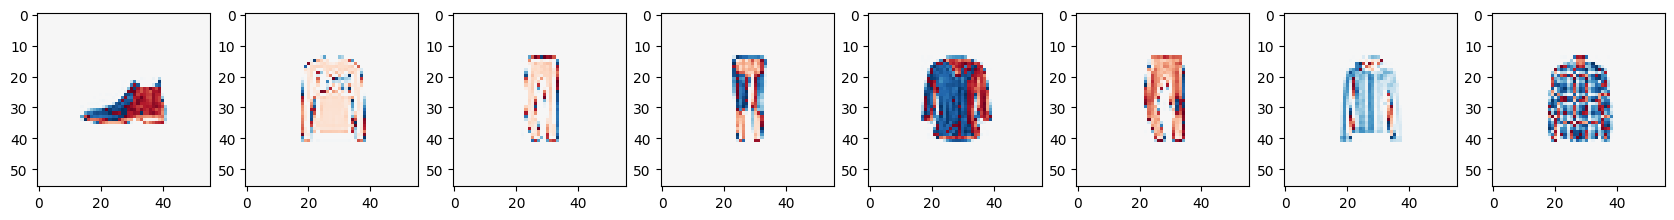

In [4]:
rows, cols = 1 ,8
fig = plt.figure(figsize=(21,8))
images, labels = next(iter(test_dataloader))
for i in range(8):
    image, label = images[i], labels[i]
    fig.add_subplot(rows,cols,i+1)
    image = np.angle(image.numpy()).squeeze()
    plt.imshow(image,cmap='RdBu')

In [5]:
def angular_spectrum_propagator(E, Nx, dx, lam, z):
    # compute angular spectrum
    fft_c = torch.fft.fft2(E)
    c = torch.fft.fftshift(fft_c)

    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d = dx))
    fxx, fyy = np.meshgrid(fx, fx)
    argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

    #Calculate the propagating and the evanescent (complex) modes
    tmp = np.sqrt(np.abs(argument))
    kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))

    # propagate the angular spectrum a distance z
    E = torch.fft.ifft2(torch.fft.ifftshift(c * torch.exp(1j * kz * z)))
    return E


class Diffraction_Layer(torch.nn.Module):
    def __init__(self, units=size):
        '''Initialize the diffraction layer attributes'''        
        super(Diffraction_Layer, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        self.dx = 100e-6
        self.lam = 0.75e-3           # wavelength of the optical wave: 0.75 mm
        self.z = 3e-2                # distance of propagation(the distance between two layers)
        shape=(self.units,self.units)
        self.phase = torch.nn.Parameter(torch.clamp(torch.empty(shape).normal_(mean = 0, std = 1), min=0, max=2*torch.pi))

    def forward(self, inputs):
        '''Define the computation'''
        return angular_spectrum_propagator(inputs, Nx = self.Nx, dx = self.dx, lam = self.lam, z = self.z) * torch.exp(1j * self.phase.type(torch.complex64))

   
class Propagation_Layer(torch.nn.Module):
    def __init__(self, units=size):
        '''Initialize the diffraction layer attributes'''
        super(Propagation_Layer, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        self.dx = 100e-6
        self.lam = 0.75e-3           # wavelength of the optical wave
        self.z = 1e-2                # distance of propagation(the distance between last layer and the detector)

    def forward(self, inputs):
        '''Define the computation'''
        return angular_spectrum_propagator(inputs, Nx = self.Nx, dx = self.dx, lam = self.lam, z = self.z)
    
class Detector(torch.nn.Module):
    def __init__(self, units=200):
        '''Initialize the instance attributes'''
        super(Detector, self).__init__()
        self.units = units
    
    def forward(self, inputs):
        ''' Converts output to one hot form
        Applies softmax'''
        
        def rang(arr,shape,size=size,base = 500):
            arr = torch.abs(arr)
            x0 = shape[0] * size // base
            y0 = shape[2] * size // base
            delta = (shape[1]-shape[0])* size // base
            return arr[x0:x0+delta,y0:y0+delta]
        
        
        return torch.cat([
            torch.cat([rang(torch.squeeze(image),(120,170,120,170)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(120,170,240,290)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(120,170,360,410)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(220,270,120,170)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(220,270,200,250)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(220,270,280,330)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(220,270,360,410)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(320,370,120,170)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(320,370,240,290)).mean().reshape(1) for image in inputs]).view(1, -1),
            torch.cat([rang(torch.squeeze(image),(320,370,360,410)).mean().reshape(1) for image in inputs]).view(1, -1),
        ]).T ** 2

In [6]:
class dnn_model(torch.nn.Module):
    def __init__(self, units=size):
        '''Initialize the diffraction layer attributes'''        
        super(dnn_model, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        self.dx = 100e-6
        self.lam = 0.75e-3           # wavelength of the optical wave: 0.75 mm
        self.z = 3e-2                # distance of propagation(the distance between two layers)

        self.h_1 = Diffraction_Layer()
        self.h_2 = Diffraction_Layer()
        self.propagation = Propagation_Layer()
        self.out = Detector()

    def forward(self,images):
        h1_image = self.h_1(images)
        h2_image = self.h_2(h1_image)
        propagated_image = self.propagation(h2_image)
        return self.out(propagated_image)
    
criterion = torch.nn.CrossEntropyLoss()
model = dnn_model()
logits = model(images)
logits, labels

(tensor([[47.1218, 27.1057, 50.8809, 29.4916, 83.6472, 92.1278, 43.9614, 51.9637,
          58.1496, 37.9700],
         [51.7847, 27.1862, 50.4764, 30.5003, 84.7903, 88.7388, 44.7155, 51.9136,
          59.2322, 37.7218],
         [50.8638, 27.0734, 51.4407, 29.7722, 83.8345, 88.4033, 44.5730, 52.4137,
          59.7814, 37.6431],
         [49.5644, 26.4680, 48.8738, 29.7108, 85.2729, 86.6274, 45.1966, 51.3727,
          60.8526, 35.9187],
         [44.4875, 24.0517, 44.4253, 27.1627, 84.3535, 90.5978, 38.0342, 49.2709,
          67.5158, 32.1209],
         [51.3330, 28.2997, 50.6152, 30.4931, 84.9742, 89.5419, 44.2418, 52.3416,
          62.3728, 36.2929],
         [46.9534, 24.6018, 49.0444, 27.7022, 81.2342, 84.2735, 41.2858, 49.9192,
          58.5493, 34.5449],
         [45.7766, 24.8856, 46.3356, 26.9795, 83.3339, 89.3597, 39.1348, 48.2533,
          61.2813, 32.2530]], dtype=torch.float64, grad_fn=<PowBackward0>),
 tensor([9, 2, 1, 1, 6, 1, 4, 6]))

In [238]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss().to(device)
model = dnn_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

for epoch in range(6):
    # train
    model.train()
    accuracies = []
    losses = []
    pbar = tqdm.tqdm(test_dataloader)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)        
        loss = criterion(logits, labels)
        losses.append(loss.item())
        accuracies.append((torch.argmax(logits, dim = 1) == labels).sum().item() / batch_size)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Mean accuracy: {torch.tensor(accuracies).mean():.5f}, mean BCE Loss: {torch.tensor(losses).mean():.5f}")    

Mean accuracy: 0.24910, mean BCE Loss: 2.07442: 100%|██████████| 1250/1250 [01:51<00:00, 11.21it/s]


In [8]:
model.load_state_dict(torch.load("weights"))

<All keys matched successfully>

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss().to(device)

model.eval()
accuracies = []
losses = []
pbar = tqdm.tqdm(test_dataloader)
for images, labels in pbar:
    images, labels = images.to(device), labels.to(device)
    logits = model(images)        
    loss = criterion(logits, labels)
    losses.append(loss.item())
    accuracies.append((torch.argmax(logits, dim = 1) == labels).sum().item() / batch_size)

    pbar.set_description(f"Mean accuracy: {torch.tensor(accuracies).mean():.5f}, mean BCE Loss: {torch.tensor(losses).mean():.5f}")    

  0%|          | 0/1250 [00:00<?, ?it/s]

Mean accuracy: 0.54800, mean BCE Loss: 1.29874: 100%|██████████| 1250/1250 [01:28<00:00, 14.08it/s]


# Legacy

In [ ]:
class Diffraction_Layer(torch.nn.Module):
    def __init__(self, units=200):
        '''Initialize the diffraction layer attributes'''
        #super().__init__()
        
        super(Diffraction_Layer, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        # self.L = 0.08              # source and observation plane side length, field of view
        dx = 100e-6
        self.lam = 0.75e-3           # wavelength of the optical wave: 0.75 mm
        self.z = 3e-2                # distance of propagation(the distance bewteen two layers)
        shape=(self.units,self.units)
        self.phase = torch.nn.Parameter(torch.clamp(torch.empty(shape).normal_(mean = 0, std = 1), min=0, max=2*torch.pi))


    def angular_spectrum_propagator(self, E):
        # compute angular spectrum
        fft_c = torch.fft.fft2(E)
        c = torch.fft.fftshift(fft_c)

        fx = np.fft.fftshift(np.fft.fftfreq(self.Nx, d = self.dx))
        fxx, fyy = np.meshgrid(fx, fx)
        argument = (2 * np.pi)**2 * ((1. / self.lam) ** 2 - fxx ** 2 - fyy ** 2)

        #Calculate the propagating and the evanescent (complex) modes
        tmp = np.sqrt(np.abs(argument))
        kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))

        # propagate the angular spectrum a distance z
        E = torch.fft.ifft2(torch.fft.ifftshift(c * torch.exp(1j * kz * self.z)))
        return E

    def forward(self, inputs):
        '''Define the computation'''
        return self.angular_spectrum_propagator(inputs) * torch.exp(1j * self.phase.type(torch.complex64))

In [ ]:
def Propagation(torch.nn.Module):
    def __init__(self, units=200):
        '''Initialize the diffraction layer attributes'''
        #super().__init__()
        
        super(Diffraction_Layer, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        # self.L = 0.08              # source and observation plane side length, field of view
        self.dx = 100e-6
        self.lam = 0.75e-3           # wavelength of the optical wave: 0.75 mm
        self.z = 3e-2                # distance of propagation(the distance bewteen two layers)
        shape=(self.units,self.units)
        self.phase = torch.nn.Parameter(torch.clamp(torch.empty(shape).normal_(mean = 0, std = 1), min=0, max=2*torch.pi))


    def angular_spectrum_propagator(self, E):
        # compute angular spectrum
        fft_c = torch.fft.fft2(E)
        c = torch.fft.fftshift(fft_c)

        fx = np.fft.fftshift(np.fft.fftfreq(self.Nx, d = self.dx))
        fxx, fyy = np.meshgrid(fx, fx)
        argument = (2 * np.pi)**2 * ((1. / self.lam) ** 2 - fxx ** 2 - fyy ** 2)

        #Calculate the propagating and the evanescent (complex) modes
        tmp = np.sqrt(np.abs(argument))
        kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))

        # propagate the angular spectrum a distance z
        E = torch.fft.ifft2(torch.fft.ifftshift(c * torch.exp(1j * kz * self.z)))
        return E

    def forward(self, inputs):
        '''Define the computation'''
        return self.angular_spectrum_propagator(inputs) 